In [2]:
# NERSC Portal site: https://portal.nersc.gov/project/dune/data/2x2/SlowControls/

In [2]:
# Data management packages
import pandas as pd
import numpy as np
import json
# Extra plotting packages
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from datetime import datetime
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.patches import Patch

In [121]:
def readData(files_list, y_axis_list, JSON=False):
    if not JSON:
        df_list = [pd.read_csv(filename, sep=',') for filename in files_list]
        df = pd.concat(df_list, ignore_index=True)
        df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')
    else:
        data = []
        # Reading JSON File
        for filename in files_list:
            with open(filename, 'r') as file:
                file_data = json.load(file)
                if isinstance(file_data, list):
                    data.extend(file_data)  # If file_data is a list, extend data
                else:
                    data.append(file_data) 
        df = pd.DataFrame(data)
        for elm in y_axis_list:
            try:
                df[elm] = df[elm].apply(lambda x: float(x.split('E')[0]) * (10 ** int(x.split('E')[1])))
            except:
                continue
        df['time'] = pd.to_datetime(df['time'], format='ISO8601').dt.tz_localize(None)
        #df['time'] = pd.to_datetime(df['time'], format='ISO8601')
        #df['time'] = df['time'].dt.strftime('%Y-%m-%d %H:%M:%S')
        #df['time'] = pd.to_datetime(df['time'], format='%Y-%m-%d %H:%M:%S')
        df = df.rename(columns={'time': 'Time'})
        df = df.sort_values('Time')

    return df

def parse_date(date_string):
    return datetime.strptime(date_string, "%m/%d/%Y-%H:%M").strftime("%Y-%m-%d %H:%M:%S")

def readLifetime(files_list, y_axis_list, JSON=False):
    df_list = [pd.read_csv(filename, sep=',') for filename in files_list]
    df = pd.concat(df_list, ignore_index=True)

    # Apply the parsing function to each element in the columns
    df['max Time'] = df['window (min)'].apply(parse_date)
    df['min Time'] = df['window (max)'].apply(parse_date)

    # Convert to datetime
    df['min Time'] = pd.to_datetime(df['min Time'])
    df['max Time'] = pd.to_datetime(df['max Time'])
    
    return df
    
def plot_data(ax, df, det_uptime, label, y_label_color, y_axis_list, legend_loc, log=False, title='', bottom_plot=False, plot_label=None, scatter=False, horizontal=[], y_limits=[], error=[]):
    for index, y_axis in enumerate(y_axis_list):
        if plot_label is None:
            if error:
                ax.errorbar(df['Time'], df[y_axis],
                    yerr=df[error[index]],
                    fmt='o', capsize=5, capthick=1, ecolor='black', markersize=4, label=y_axis, color=y_label_color[index])
            elif not scatter:
                ax.plot(df['Time'], df[y_axis], label=y_axis, color=y_label_color[index])
            else:
                ax.scatter(df['Time'], df[y_axis], label=y_axis, color=y_label_color[index], s=1)
        else:
            if error:
                ax.errorbar(df['Time'], df[y_axis],
                    yerr=df[error[index]],
                    fmt='o', capsize=5, capthick=1, ecolor='black', markersize=4, label=plot_label[index], color=y_label_color[index])
            elif not scatter:
                ax.plot(df['Time'], df[y_axis], label=plot_label[index], color=y_label_color[index])
            else:
                ax.scatter(df['Time'], df[y_axis], label=plot_label[index], color=y_label_color[index], s=1)
    if log:
        ax.set_yscale('log')
    ax.grid(True, linestyle=':', linewidth=0.5, color='gray')
    ax.set_ylabel('Value', labelpad=5)
    if not bottom_plot:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:
        ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
        ax.spines['bottom'].set_visible(True)
    ax.set_ylabel(label, fontsize=12, color=y_label_color[0])
    ax.legend(loc=legend_loc, fontsize='medium', ncol=2, framealpha=1)
    
    if horizontal:
        for line in horizontal:
            limit, name, color = line[0], line[1], line[2]
            ax.axhline(y=limit, color=color, linestyle='--', linewidth=1)
            ax.text(
            x=0.02,  # x-coordinate (in axes fraction)
            y=limit,  # y-coordinate (in data units)
            s=name,  # The text to display
            fontsize=12, 
            color=color,
            verticalalignment='bottom',  # Place text above the line
            horizontalalignment='left',  # Align text to the left
            transform=ax.get_yaxis_transform()  # Use a blend of data and axes coordinates
        )
    if y_limits:
        ax.set_ylim(*y_limits)
        
    # Color the background for each period in result
    for _, row in det_uptime.iterrows():
        ax.axvspan(row['Start'], row['End'], facecolor='blue', alpha=0.1)
    
def add_subplot(fig, main_ax, df, label, y_label_color, y_axis_list, legend_loc, position='right', width_ratio=0.3, log=False, plot_label=None, y_limits=[], error=[]):

    ax = main_ax.twinx()

    # Plot data on the new axes
    for index, y_axis in enumerate(y_axis_list):
        if plot_label is None:
            if error:
                ax.errorbar(df['Time'], df[y_axis],
                    yerr=df[error[index]],
                    fmt='o', capsize=5, capthick=1, ecolor='black', markersize=4, label=y_axis, color=y_label_color[index])
            else:
                ax.plot(df['Time'], df[y_axis], label=y_axis, color=y_label_color[index])
        else:
            if error:
                ax.errorbar(df['Time'], df[y_axis],
                    yerr=df[error[index]],
                    fmt='o', capsize=5, capthick=1, ecolor='black', markersize=4, label=plot_label[index], color=y_label_color[index])
            else:
                ax.plot(df['Time'], df[y_axis], label=plot_label[index], color=y_label_color[index])
    if log:
        ax.set_yscale('log')
    ax.grid(True, linestyle=':', linewidth=0.5, color='gray')
    ax.set_ylabel(label, fontsize=12, color=y_label_color[0])
    ax.legend(loc=legend_loc, fontsize='medium', ncol=1, framealpha=1)

    # Synchronize x-axis limits with the main plot
    ax.set_xlim(main_ax.get_xlim())
    
    if y_limits:
        ax.set_ylim(*y_limits)

    # Remove x-axis labels if the subplot is on top
    if position == 'top':
        ax.tick_params(axis='x', which='both', bottom=False, top=True, labelbottom=False, labeltop=True)
        ax.xaxis.set_label_position('top')
    
    return ax
    
def HV_status(ax, df, label, y_label_color, y_axis_list, log=False, title='', bottom_plot=False):
    for y_axis in y_axis_list:
        if df[y_axis].isin([0, 1]).all():
            df['diff'] = df[y_axis].diff().fillna(0).ne(0).astype(int).cumsum()
            for val in df[y_axis].unique():
                regions = df[df[y_axis] == val].groupby('diff')['Time'].agg(['first', 'last'])
                color = 'green' if val == 1 else 'red'
                for _, (start, end) in regions.iterrows():
                    ax.axvspan(start, end, facecolor=color, alpha=1)
            df.drop(columns=['diff'], inplace=True)
    
    if log:
        ax.set_yscale('log')
    ax.grid(True, linestyle=':', linewidth=0.5, color='gray')
    
    if not bottom_plot:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    else:
        ax.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
        ax.spines['bottom'].set_visible(True)
    # Hide the y-axis ticks and labels
    #ax.yaxis.set_visible(False)
    # Show the y-axis title
    ax.set_yticks([])
    ax.set_ylabel(label, fontsize=12, color=y_label_color, rotation=0, ha='right', va='center')
    
def RunNumber(ax, run_df, label, y_label_color):
    
    # Hide all spines and ticks
    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.set_yticks([])

    # Set x-axis to show dates
    ax.xaxis_date()
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    
    # Adjust the x-axis major locator based on the range of dates
    date_range = (run_df['End'].max() - run_df['Start'].min()).days
    if date_range <= 10:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=1))
    elif date_range <= 30:
        ax.xaxis.set_major_locator(mdates.DayLocator(interval=3))
    elif date_range <= 90:
        ax.xaxis.set_major_locator(mdates.WeekLocator())
    else:
        ax.xaxis.set_major_locator(mdates.MonthLocator())

    plt.xticks(rotation=45, ha='right')

    # Set x-axis limits
    ax.set_xlim(run_df['Start'].min(), run_df['End'].max())

    # Plot each run
    for _, row in run_df.iterrows():
        start = row['Start']
        end = row['End']
        
        # Add colored span
        ax.axvspan(start, end, facecolor='blue', alpha=0.3)
        
        # If we have a Run number, add text 'a'
        if pd.notna(row['Run']):
            mid_point = start + (end - start) / 2
            ax.text(mid_point, 0.5, row['Run'], 
                    ha='center', va='center', fontweight='bold')
            
    ax.set_yticks([])
    ax.set_ylabel(label, fontsize=12, color=y_label_color, rotation=0, ha='right', va='center')


In [4]:
# Reading data from files

# LIGHT READOUT 
lro = readData(['LRO/lrs_monitor_mstream.fragments.assemble.complete_2024-07-01T00:00:00-05:00_2024-07-12T23:59:59.999999-05:00.json'], ['value'], JSON=True)
# Filter the DataFrame for the specific serial number
lro['serial'] = lro['tags'].apply(lambda x: x.get('serial'))
df_filtered = lro[lro['serial'] == '0CD9-415C']
df_filtered = df_filtered[df_filtered['value'] > 10]
# Set 'Time' as the index
df_filtered.set_index('Time', inplace=True)
# Resample to 10-second intervals and sum the values
df_resampled = df_filtered.resample('10s')['value'].sum()
# Calculate the non-negative difference
df_diff = df_resampled.diff().clip(lower=0)
# Divide by 1300 to get event rate
df_result = df_diff / 1300
# Reset index to make 'Time' a column again if needed
lro = df_result.reset_index()
lro = lro[lro['value']>10]

# CHARGE READOUT
cro = readData(['CRO/Data Rate by Pacman (10s mean)-data-as-joinbyfield-2024-07-10 12_17_05.csv'], ['P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8'])

# HIGH VOLTAGE
hv = readData(['HV/HVmonitoring_SPELLMAN_HV_2024-07-01T00:00:00-05:00_2024-07-12T23:59:59.999999-05:00.json'],['Enabled'],JSON=True)
pfd4 = readData(['HV/HVmonitoring_Raspi_2024-07-01T00:00:00-05:00_2024-07-12T23:59:59.999999-05:00.json'],['CH1','CH2','CH3','CH4'],JSON=True)
def is_near_target(value, targets=[-15, -7.5], tolerance=1):
    return any(abs(value - target) <= tolerance for target in targets)
pfd4['All_Near_Target'] = pfd4[['CH1', 'CH2', 'CH3', 'CH4']].apply(lambda row: all(is_near_target(value) for value in row), axis=1)
# Identify changes in the 'All_Near_Target' column
pfd4['change'] = pfd4['All_Near_Target'].diff().ne(0)
pfd4['group'] = pfd4['change'].cumsum()
# Group by the sequences and extract start and end times
result = pfd4.groupby(['group', 'All_Near_Target']).agg({'Time': ['first', 'last']})
result.columns = ['Start', 'End']
result = result.reset_index()
# Keep only the rows where All_Near_Target is True
result = result[result['All_Near_Target'] == True]
# Format the result
det_uptime = result[['Start', 'End']].sort_values('Start')

# CRYOGENICS
cryo1 = readData(['CRYOGENICS/cryo_readonly_AE-1015A_2024-07-01T00:00:00-05:00_2024-07-12T23:59:59.999999-05:00.json'],['magnitude'],JSON=True)
cryo1['magnitude'] = cryo1['magnitude'] - 9.5 
cryo2 = readData(['CRYOGENICS/Level Raspi-data-2024-07-17 00_45_57.csv'],['B'])

# NUMI BEAM
POT = readData(['POT/BeamPOT_2024-07-01T00:00:00-05:00_2024-07-12T23:59:59.999999-05:00.json'],['value'],JSON=True)
POT['time_diff_seconds'] = POT['Time'].diff().dt.total_seconds()
POT = POT[POT['value'] > 2.0E12]
POT['cumulative_POT'] = POT['value'].cumsum()
# Initialize an empty column for cumulative sums
POT['cumulative_by_uptime'] = 0.0
# Calculate cumulative values for each uptime interval
for _, row in det_uptime.iterrows():
    start = row['Start']
    end = row['End']
    # Filter pot dataframe for the current interval
    mask = (POT['Time'] >= start) & (POT['Time'] <= end)
    filtered_pot = POT[mask]
    # Calculate the cumulative sum row by row within the interval
    POT.loc[mask, 'cumulative_by_uptime'] = filtered_pot['value'].cumsum()
    
# Set cumulative value to zero for periods outside the uptime intervals
outside_intervals = ~POT.apply(lambda row: any((row['Time'] >= det_uptime['Start']) & (row['Time'] <= det_uptime['End'])), axis=1)
POT.loc[outside_intervals, 'cumulative_by_uptime'] = None

# ELECTRON LIFETIME
electron = readLifetime(['LIFETIME/lifetime.csv'],[])
# Create dataframe for min times
df_min = electron[['min Time', 'lifetime [microseconds]', 'lifetime uncertainty [microseconds]']].copy()
df_min['Time_type'] = 'min'
df_min = df_min.rename(columns={'min Time': 'Time'})

# Create dataframe for max times
df_max = electron[['max Time', 'lifetime [microseconds]', 'lifetime uncertainty [microseconds]']].copy()
df_max['Time_type'] = 'max'
df_max = df_max.rename(columns={'max Time': 'Time'})

# Concatenate the dataframes
df_unified = pd.concat([df_min, df_max], ignore_index=True)

# Sort by the Time column
electron = df_unified.sort_values('Time').reset_index(drop=True)

# Determine the overall time range
all_dfs = [lro, hv, pfd4, cryo1, cryo2, POT]
min_time = min(df['Time'].min() for df in all_dfs)
max_time = max(df['Time'].max() for df in all_dfs)

In [84]:
# Create the purity monitor data
data = {
    'Time': [datetime(2024, 7, 1, 10, 0), datetime(2024, 7, 12, 10, 0)],
    'lifetime [microseconds]': [65, 2000],
    'lifetime uncertainty [microseconds]': [20, 100]
}

# Create the DataFrame
purityMonitor = pd.DataFrame(data)

# Adding global run numbers
det_uptime['Run'] = [None, '50005', '50011', '50017-50018', None]

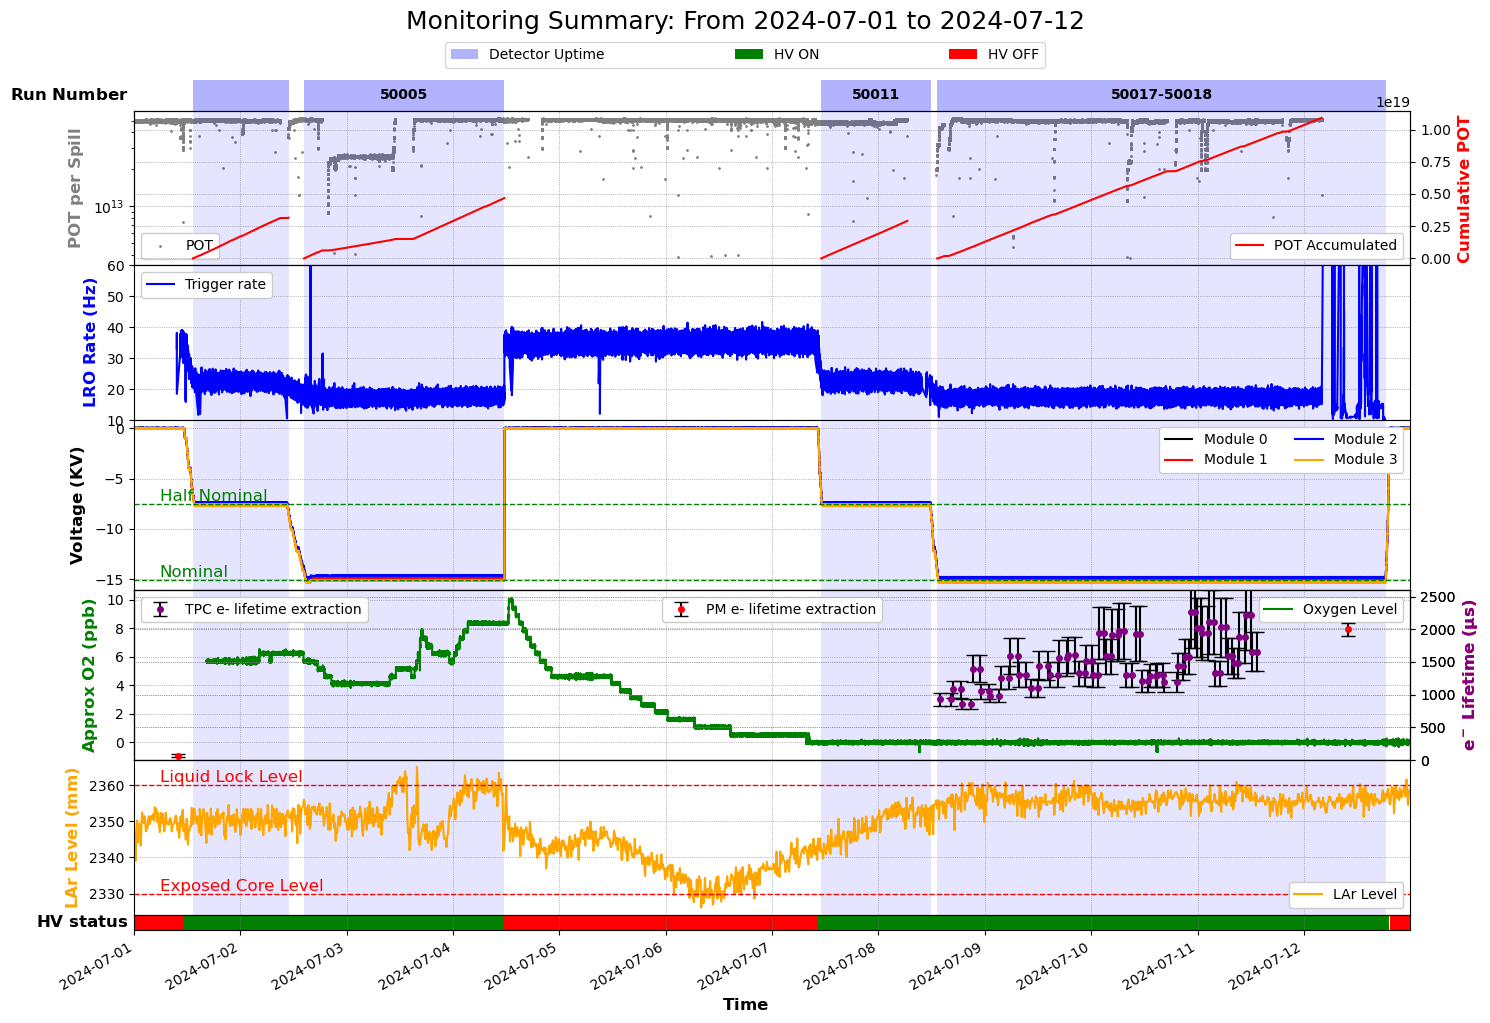

In [122]:
# Create a single figure with subplots
fig, axs = plt.subplots(7, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [0.2, 1, 1, 1.1, 1.1, 1, 0.1]})
fig.subplots_adjust(hspace=0)  # Remove space between subplots
title = 'Monitoring Summary: From ' + str(min_time).split(" ")[0] + ' to ' + str(max_time).split(" ")[0]
fig.suptitle(title, fontsize=18, y=1.02) 

# Plot each dataset
RunNumber(axs[0], det_uptime, label=r'$\bf{Run\ Number}$', y_label_color='black')
#plot_data(axs[0], POT, label=r'$\bf{Cumulative\ POT}$', y_label_color=['red'], y_axis_list=['cumulative_POT'], legend_loc=3, title='POT', plot_label='POT Accumulated', log=True)
plot_data(axs[1], POT, det_uptime, label=r'$\bf{POT\ per\ Spill}$', y_label_color=['gray'], y_axis_list=['value'], legend_loc=3, title='POT', plot_label=['POT'], log=True, scatter=True)
#plot_data(axs[0], POT, det_uptime, label=r'$\bf{Time\ Diff}$', y_label_color=['gray'], y_axis_list=['time_diff_seconds'], legend_loc=3, title='POT', plot_label=['time_diff_seconds'], scatter=True, y_limits=[0.8,1.6])
add_subplot(fig, axs[1], POT, label=r'$\bf{Cumulative\ POT}$', y_label_color=['red'], y_axis_list=['cumulative_by_uptime'], legend_loc=4, position='right', plot_label=['POT Accumulated'])
#add_subplot(fig, axs[0], POT, label='POT', y_label_color=['pink'], y_axis_list=['value'], legend_loc=4, position='right', plot_label='POT', log=True)
plot_data(axs[2], lro, det_uptime, label=r'$\bf{LRO\ Rate\ (Hz)}$', y_label_color=['blue'], y_axis_list=['value'], legend_loc=2, title='LRO', plot_label=['Trigger rate'], y_limits=[10,60])
plot_data(axs[3], pfd4, det_uptime, label=r'$\bf{Voltage\ (KV)}$', y_label_color=['black','red','blue','orange'],  y_axis_list=['CH1','CH2','CH3','CH4'], legend_loc=1, title='PFD4', plot_label=['Module 0','Module 1','Module 2','Module 3'], horizontal=[[-7.5,'Half Nominal','green'],[-15.1,'Nominal','green']])
plot_data(axs[4], cryo1, det_uptime, label=r'$\bf{Approx\ O2\ (ppb)}$', y_label_color=['green'], y_axis_list=['magnitude'], legend_loc=1, title='CRYO1', plot_label=['Oxygen Level'])
#plot_data(axs[3], electron, det_uptime, label=r'$\bf{e^-\ Lifetime\ \mu s}$', y_label_color=['green'], y_axis_list=['lifetime [microseconds]'], legend_loc=2, title='eLifetime', plot_label=['TPC e- lifetime extraction'], y_limits=[0,2600], error=['lifetime uncertainty [microseconds]'])
add_subplot(fig, axs[4], purityMonitor, label=r'$\bf{e^-\ Lifetime\ (\mu s)}$', y_label_color=['red'], y_axis_list=['lifetime [microseconds]'], legend_loc='upper center', position='right', plot_label=['PM e- lifetime extraction'], y_limits=[0,2600], error=['lifetime uncertainty [microseconds]'])
add_subplot(fig, axs[4], electron, label=r'$\bf{e^-\ Lifetime\ (\mu s)}$', y_label_color=['purple'], y_axis_list=['lifetime [microseconds]'], legend_loc=2, position='right', plot_label=['TPC e- lifetime extraction'], y_limits=[0,2600], error=['lifetime uncertainty [microseconds]'])
plot_data(axs[5], cryo2, det_uptime, label=r'$\bf{LAr\ Level\ (mm)}$', y_label_color=['orange'], y_axis_list=['B'], legend_loc=4, title='CRYO2', plot_label=['LAr Level'], horizontal=[[2360, 'Liquid Lock Level', 'red'],[2330, 'Exposed Core Level', 'red']])
HV_status(axs[6], hv, label=r'$\bf{HV\ status}$', y_label_color='black', y_axis_list=['Enabled'], title='HV', bottom_plot=True)

# Set the x-axis limits to the overall min and max
axs[0].set_xlim([min_time, max_time])

# Set up the x-axis to show all days
for ax in axs:
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))

# Rotate and align the tick labels so they look better
fig.autofmt_xdate()

# Add an overall x-axis label
fig.text(0.5, 0.02, r'$\bf{Time}$', ha='center', fontsize=12)

plt.tight_layout()

# Remove any remaining space
plt.subplots_adjust(hspace=0, top=0.95, bottom=0.1)

# Create custom legend elements
legend_elements = [
    Patch(facecolor='blue', alpha=0.3, label='Detector Uptime'),
    Patch(facecolor='green', label='HV ON'),
    Patch(facecolor='red', label='HV OFF')
]

# Create a new axes for the legend
legend_ax = fig.add_axes([0.3, 0.95, 0.4, 0.05], frame_on=False)  # [left, bottom, width, height]
legend_ax.axis('off')

# Add the custom legend to the new axes
legend = legend_ax.legend(handles=legend_elements, loc='center', ncol=3, mode="expand", borderaxespad=0.)

plt.subplots_adjust(top=0.95)

# Adjust layout
plt.show()
fig.savefig('plot.png', bbox_inches='tight')